In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install opencv-python

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),                # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

In [ ]:
train_data = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_data = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform
)

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

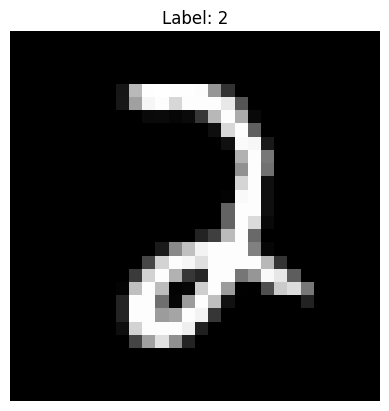

In [ ]:
images, labels = next(iter(train_loader))

plt.imshow(images[0].squeeze(), cmap="gray")
plt.title(f"Label: {labels[0]}")
plt.axis("off")

In [ ]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)

        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.1476
Epoch 2, Loss: 0.0445
Epoch 3, Loss: 0.0298
Epoch 4, Loss: 0.0231
Epoch 5, Loss: 0.0174


In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.12%


In [ ]:
torch.save(model.state_dict(), "digit_model.pth")

TEST WITH YOUR MY HANDWRITTEN IMAGE

In [ ]:
def preprocess_image(image_path):
    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize to 28x28
    img = cv2.resize(img, (28, 28))

    # Invert colors (black bg, white digit)
    img = 255 - img

    # Normalize pixel values
    img = img / 255.0

    # Convert to tensor
    img = torch.tensor(img, dtype=torch.float32)

    # Add batch and channel dimensions
    img = img.unsqueeze(0).unsqueeze(0)

    return img

In [ ]:
model = DigitCNN()
model.load_state_dict(torch.load("/content/digit_model.pth", map_location="cpu"))
model.eval()

DigitCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
image_path = "/content/test 1.png" # Using an existing image file
img = preprocess_image(image_path)

with torch.no_grad():
    output = model(img)
    prediction = torch.argmax(output).item()

print("Predicted Digit:", prediction)

Predicted Digit: 2


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

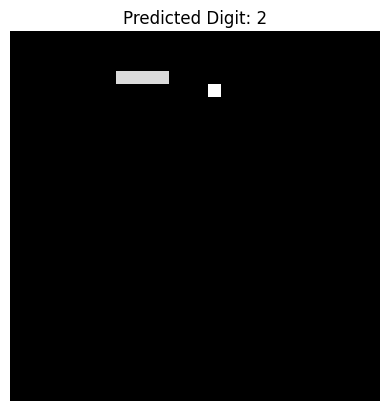

In [ ]:
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Predicted Digit: {prediction}")
plt.axis("off")

TEST NON-MNIST DATASET

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Stack images into a single tensor
stacked_images = torch.cat(images, dim=0)

# Convert labels to a tensor
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Create the TensorDataset
non_mnist_dataset = TensorDataset(stacked_images, labels_tensor)

print(f"Total non-MNIST samples: {len(non_mnist_dataset)}")

Total non-MNIST samples: 107730


In [ ]:
from torch.utils.data import random_split

# Split the dataset into training and validation sets
train_size = int(0.8 * len(non_mnist_dataset))
val_size = len(non_mnist_dataset) - train_size

non_mnist_train_dataset, non_mnist_val_dataset = random_split(non_mnist_dataset, [train_size, val_size])

print(f"Non-MNIST Training samples: {len(non_mnist_train_dataset)}")
print(f"Non-MNIST Validation samples: {len(non_mnist_val_dataset)}")

# Create DataLoaders
batch_size = 64
non_mnist_train_loader = DataLoader(non_mnist_train_dataset, batch_size=batch_size, shuffle=True)
non_mnist_val_loader = DataLoader(non_mnist_val_dataset, batch_size=batch_size, shuffle=False)

print("Non-MNIST DataLoaders created successfully.")

Non-MNIST Training samples: 86184
Non-MNIST Validation samples: 21546
Non-MNIST DataLoaders created successfully.


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Optimizer reset successfully for fine-tuning.")

Optimizer reset successfully for fine-tuning.


In [ ]:
model = DigitCNN()
model.load_state_dict(torch.load("/content/digit_model.pth", map_location="cpu"))
model.to(device) # Move the model to the correct device (GPU if available)
model.eval()

DigitCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
fine_tune_epochs = 5 # Set the number of fine-tuning epochs

print(f"Starting fine-tuning for {fine_tune_epochs} epochs...")

for epoch in range(fine_tune_epochs):
    model.train() # Set model to training mode
    running_loss = 0

    for images, labels in non_mnist_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Fine-tune Epoch {epoch+1}, Loss: {running_loss/len(non_mnist_train_loader):.4f}")

print("Fine-tuning complete.")

Starting fine-tuning for 5 epochs...
Fine-tune Epoch 1, Loss: 2.3052
Fine-tune Epoch 2, Loss: 2.3028
Fine-tune Epoch 3, Loss: 2.3027
Fine-tune Epoch 4, Loss: 2.3027
Fine-tune Epoch 5, Loss: 2.3027
Fine-tuning complete.


In [ ]:
model.eval() # Set the model to evaluation mode
correct, total = 0, 0

with torch.no_grad():
    for images, labels in non_mnist_val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Non-MNIST Validation Accuracy: {100 * correct / total:.2f}%")

Non-MNIST Validation Accuracy: 10.04%


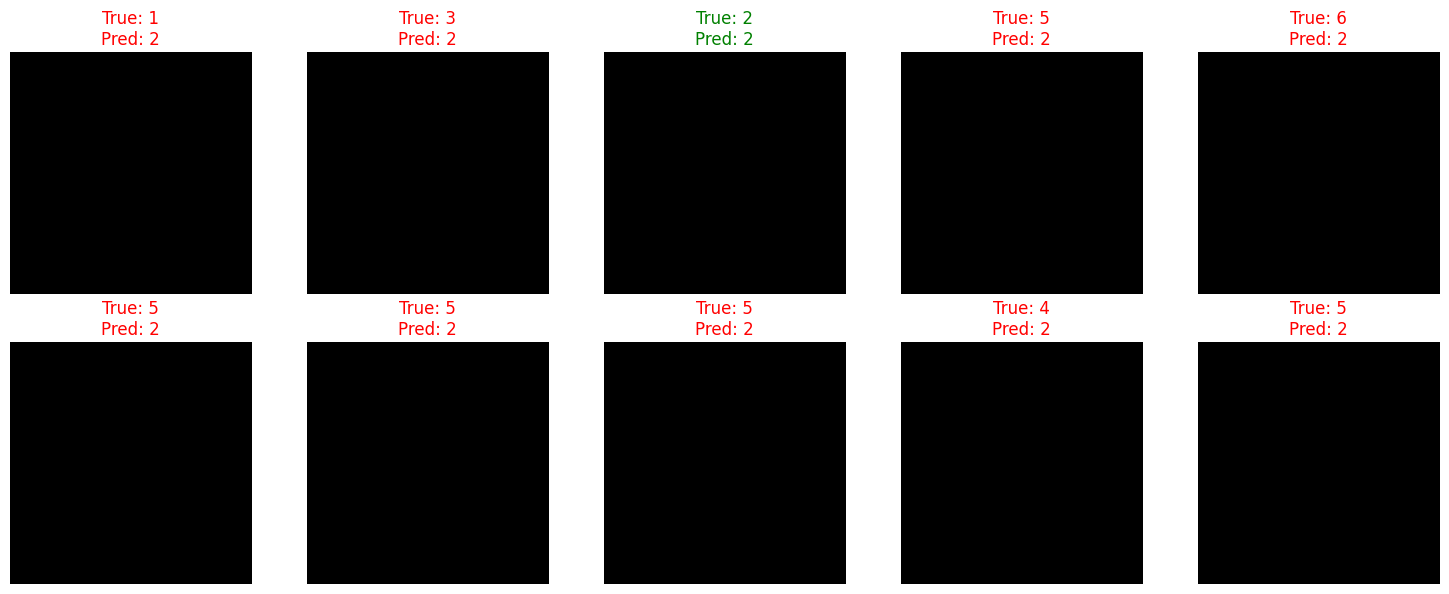

In [ ]:
import matplotlib.pyplot as plt

model.eval() # Set the model to evaluation mode

# Get a batch of images and labels from the validation loader
images, labels = next(iter(non_mnist_val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Display several images with true and predicted labels
num_images_to_display = 10 # You can adjust this number

plt.figure(figsize=(15, 6))
for i in range(num_images_to_display):
    ax = plt.subplot(2, 5, i + 1) # Adjust subplot grid based on num_images_to_display

    # Squeeze the image tensor and convert to numpy for plotting
    img_np = images[i].cpu().squeeze().numpy()

    # Denormalize the image for better visualization (optional, depending on the transform)
    # The transform was transforms.Normalize((0.5,), (0.5,)), so to reverse:
    # img_np = img_np * 0.5 + 0.5

    plt.imshow(img_np, cmap='gray')

    true_label = labels[i].item()
    pred_label = predicted[i].item()

    title_color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()